uno nuevo, no quiero que se vean los textos:


🔌 SISTEMA DE ANÁLISIS DE FRECUENCIA ELÉCTRICA - COES PERÚ
🌐 Versión Google Colab

📋 INSTRUCCIONES:
1. Ajusta la fecha usando los controles deslizantes
2. Haz clic en '📡 Obtener Datos' para descargar desde COES
3. Configura el período de tiempo a analizar
4. Haz clic en '📊 Analizar Período' para generar gráficos
5. Usa '💾 Exportar Datos' para descargar los resultados
🚀 Iniciando Analizador de Frecuencia COES...
📱 Compatible con Google Colab

🔌 ANALIZADOR DE FRECUENCIA ELÉCTRICA - COES PERÚ


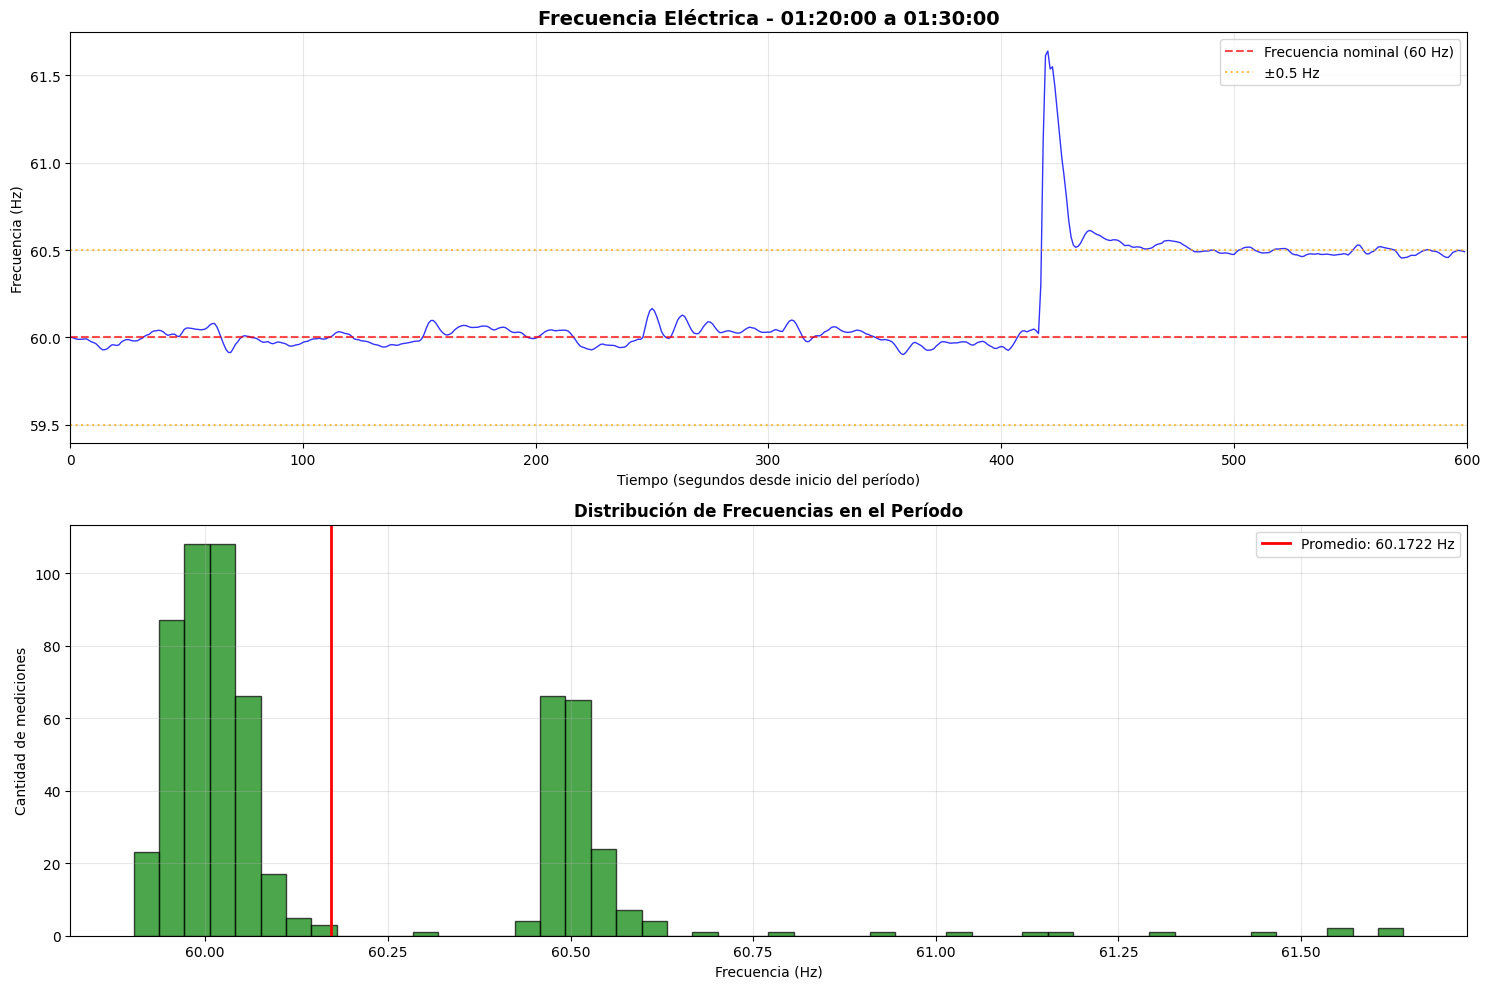

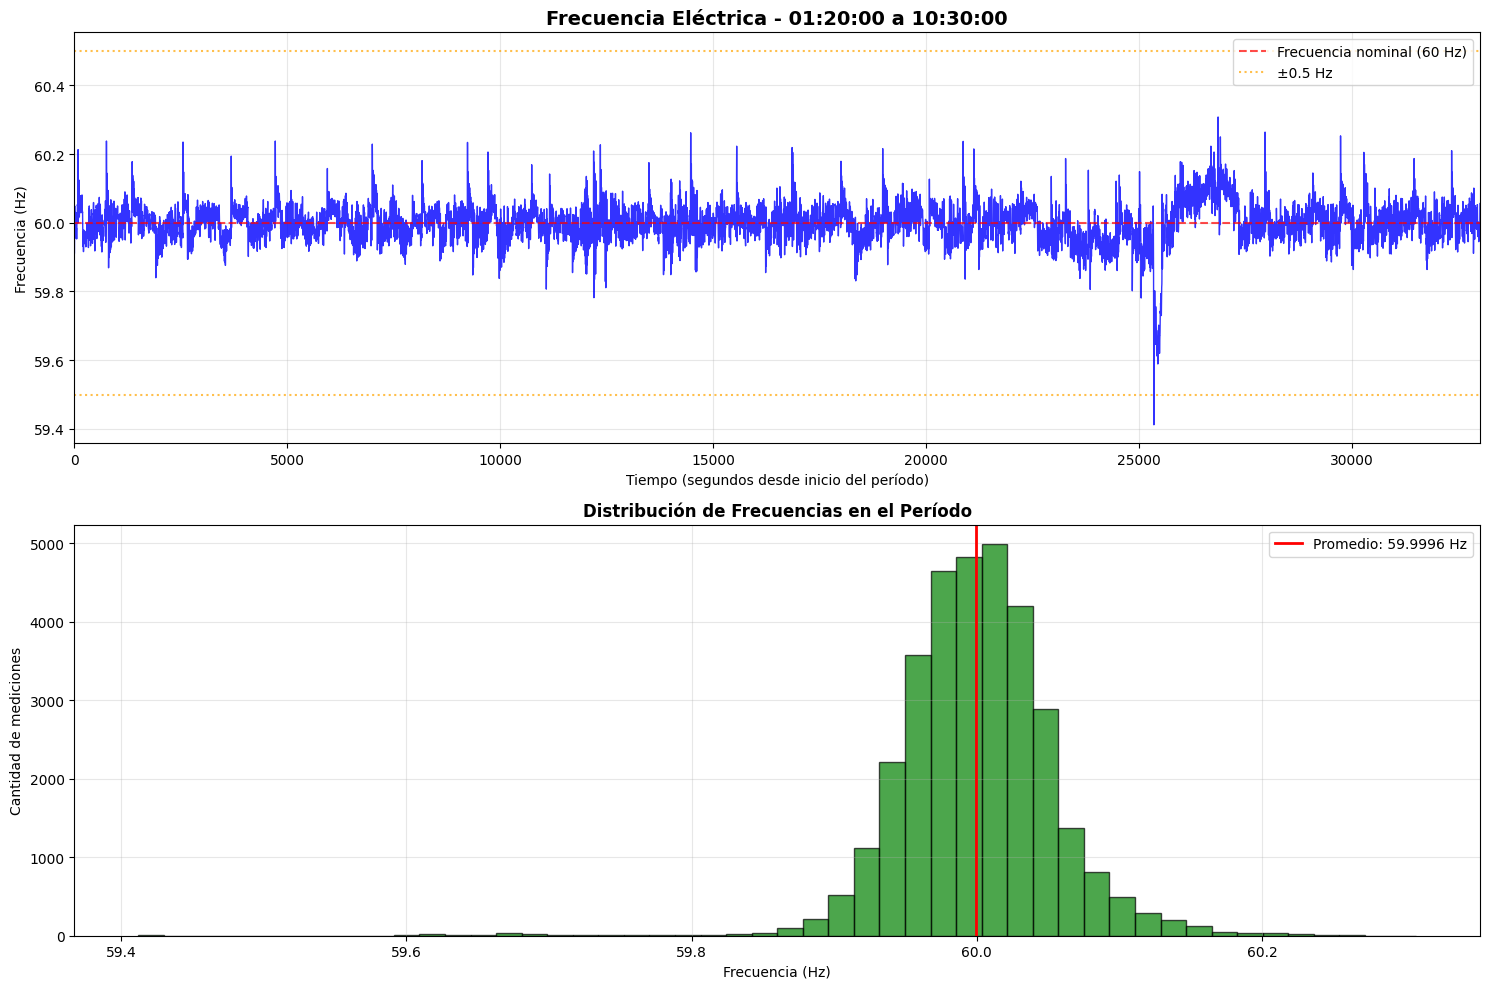

In [2]:
# @title
# Instalar dependencias necesarias
!pip install -q matplotlib pandas requests ipywidgets

from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import requests
import ipywidgets as widgets
from IPython.display import display, clear_output
import io
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

class COESFrequencyAnalyzer:
    def __init__(self):
        # Variables para almacenar datos
        self.df = None
        self.l_frec = []
        self.l_hora_t = []
        self.l_frec_periodo = []
        self.l_hora_periodo = []
        self.i1 = 0
        self.i2 = 0

        # Crear widgets
        self.create_widgets()

    def create_widgets(self):
        """Crear interfaz con widgets de Jupyter"""
        # Título
        print("🔌 ANALIZADOR DE FRECUENCIA ELÉCTRICA - COES PERÚ")
        print("="*60)

        # Widgets de entrada de fecha
        self.dia_widget = widgets.IntSlider(
            value=26, min=1, max=31, step=1, description='Día:'
        )
        self.mes_widget = widgets.IntSlider(
            value=8, min=1, max=12, step=1, description='Mes:'
        )
        self.ano_widget = widgets.IntSlider(
            value=2025, min=2020, max=2030, step=1, description='Año:'
        )

        # Botón para obtener datos
        self.btn_obtener = widgets.Button(
            description='📡 Obtener Datos',
            button_style='primary',
            tooltip='Descargar datos desde COES',
            icon='download'
        )
        self.btn_obtener.on_click(self.obtener_datos)

        # Widgets para configuración del período
        self.hora_inicio_widget = widgets.Text(
            value='01:20:00',
            placeholder='HH:MM:SS',
            description='Hora inicio:',
            style={'description_width': 'initial'}
        )
        self.hora_fin_widget = widgets.Text(
            value='01:30:00',
            placeholder='HH:MM:SS',
            description='Hora fin:',
            style={'description_width': 'initial'}
        )

        # Botones de análisis y exportación
        self.btn_analizar = widgets.Button(
            description='📊 Analizar Período',
            button_style='success',
            disabled=True,
            icon='bar-chart'
        )
        self.btn_analizar.on_click(self.analizar_periodo)

        self.btn_exportar = widgets.Button(
            description='💾 Exportar Datos',
            button_style='info',
            disabled=True,
            icon='download'
        )
        self.btn_exportar.on_click(self.exportar_datos)

        # Widget de salida para información
        self.output = widgets.Output()

        # Mostrar interfaz
        fecha_box = widgets.HBox([self.dia_widget, self.mes_widget, self.ano_widget])
        periodo_box = widgets.HBox([self.hora_inicio_widget, self.hora_fin_widget])
        botones_box = widgets.HBox([self.btn_obtener, self.btn_analizar, self.btn_exportar])

        display(widgets.VBox([
            widgets.HTML("<h3>📅 Seleccionar Fecha</h3>"),
            fecha_box,
            widgets.HTML("<h3>⏰ Configurar Período de Análisis</h3>"),
            periodo_box,
            widgets.HTML("<h3>🎛️ Controles</h3>"),
            botones_box,
            widgets.HTML("<h3>📋 Información del Proceso</h3>"),
            self.output
        ]))

    def log_info(self, mensaje):
        """Agregar información al área de salida"""
        with self.output:
            print(f"🕐 {datetime.now().strftime('%H:%M:%S')} - {mensaje}")

    def obtener_datos(self, b):
        """Obtener datos de la API del COES"""
        with self.output:
            clear_output(wait=True)

        try:
            dia = self.dia_widget.value
            mes = self.mes_widget.value
            ano = self.ano_widget.value

            # Validar fecha
            fecha = date(ano, mes, dia)

            self.log_info(f"🔄 Obteniendo datos para {dia:02d}/{mes:02d}/{ano}...")

            # Construir URL
            link = f'https://appserver.coes.org.pe/waMediciones/api/Frecuencia?fecha={ano} {mes} {dia}'
            self.log_info(f"🔗 URL: {link}")

            # Realizar petición
            with self.output:
                print("⏳ Conectando con la API del COES...")

            response = requests.get(link, timeout=30)
            response.raise_for_status()

            # Procesar datos
            self.df = pd.DataFrame.from_dict(response.json())

            if self.df.empty:
                raise ValueError("No se encontraron datos para la fecha especificada")

            self.log_info(f"✅ Datos obtenidos exitosamente. Registros: {len(self.df)}")

            # Mostrar información del DataFrame
            with self.output:
                print(f"📊 Estructura de datos:")
                print(f"   - Filas: {self.df.shape[0]}")
                print(f"   - Columnas: {self.df.shape[1]}")
                print(f"   - Columnas disponibles: {list(self.df.columns)}")

            # Procesar datos temporales
            self.procesar_datos_temporales(ano, mes, dia)

            # Habilitar botón de análisis
            self.btn_analizar.disabled = False
            self.log_info("✅ Datos procesados. Puede proceder con el análisis.")

        except requests.exceptions.RequestException as e:
            self.log_info(f"❌ Error de conexión: {str(e)}")
        except ValueError as e:
            self.log_info(f"❌ Error de datos: {str(e)}")
        except Exception as e:
            self.log_info(f"❌ Error inesperado: {str(e)}")

    def procesar_datos_temporales(self, ano, mes, dia):
        """Procesar datos temporales similar al código original"""
        self.l_frec = []
        self.l_hora_t = []

        newdate = datetime(ano, mes, dia, 0, 0, 0, 0)

        self.log_info("🔄 Procesando datos temporales...")

        for i in range(1, len(self.df) + 1):
            # Obtener valores de frecuencia (columnas 2 en adelante)
            frec_values = list(self.df.iloc[-i, 2:].values)
            # Filtrar valores no nulos
            frec_values = [float(val) for val in frec_values if pd.notna(val)]
            self.l_frec += frec_values

            # Generar timestamps para cada segundo (60 por minuto)
            for j in range(len(frec_values)):
                self.l_hora_t.append(newdate.strftime("%H:%M:%S"))
                newdate = newdate + timedelta(seconds=1)

        self.log_info(f"✅ Procesamiento completado. Total de mediciones: {len(self.l_frec)}")

        # Mostrar algunas estadísticas generales
        if self.l_frec:
            freq_min = min(self.l_frec)
            freq_max = max(self.l_frec)
            freq_prom = sum(self.l_frec) / len(self.l_frec)

            with self.output:
                print(f"📈 Estadísticas generales del día:")
                print(f"   - Frecuencia mínima: {freq_min:.3f} Hz")
                print(f"   - Frecuencia máxima: {freq_max:.3f} Hz")
                print(f"   - Frecuencia promedio: {freq_prom:.3f} Hz")
                print(f"   - Período disponible: {self.l_hora_t[0]} a {self.l_hora_t[-1]}")

    def analizar_periodo(self, b):
        """Analizar el período específico"""
        try:
            hora_inicio = self.hora_inicio_widget.value
            hora_fin = self.hora_fin_widget.value

            # Encontrar índices
            if hora_inicio not in self.l_hora_t:
                available_hours = [self.l_hora_t[i] for i in range(0, len(self.l_hora_t), 3600)][:10]
                raise ValueError(f"Hora de inicio {hora_inicio} no encontrada. Horas disponibles: {available_hours}")
            if hora_fin not in self.l_hora_t:
                raise ValueError(f"Hora de fin {hora_fin} no encontrada en los datos")

            self.i1 = self.l_hora_t.index(hora_inicio)
            self.i2 = self.l_hora_t.index(hora_fin)

            if self.i2 <= self.i1:
                raise ValueError("La hora de fin debe ser posterior a la hora de inicio")

            self.log_info(f"🔍 Analizando período de {hora_inicio} a {hora_fin}")
            self.log_info(f"📊 Índices: {self.i1} a {self.i2} ({self.i2-self.i1} segundos)")

            # Extraer datos del período
            self.l_frec_periodo = self.l_frec[self.i1:self.i2]
            self.l_hora_periodo = self.l_hora_t[self.i1:self.i2]

            # Calcular estadísticas
            freq_min = min(self.l_frec_periodo)
            freq_max = max(self.l_frec_periodo)
            freq_prom = sum(self.l_frec_periodo) / len(self.l_frec_periodo)
            freq_std = pd.Series(self.l_frec_periodo).std()

            self.log_info(f"📊 Estadísticas del período:")
            with self.output:
                print(f"   - Frecuencia mínima: {freq_min:.4f} Hz")
                print(f"   - Frecuencia máxima: {freq_max:.4f} Hz")
                print(f"   - Frecuencia promedio: {freq_prom:.4f} Hz")
                print(f"   - Desviación estándar: {freq_std:.4f} Hz")
                print(f"   - Variación total: {freq_max - freq_min:.4f} Hz")

            # Crear gráfico
            self.crear_grafico()

            # Habilitar exportación
            self.btn_exportar.disabled = False

        except Exception as e:
            self.log_info(f"❌ Error en análisis: {str(e)}")

    def crear_grafico(self):
        """Crear gráfico de frecuencia"""
        self.log_info("📊 Generando gráfico...")

        # Crear figura con subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

        # Gráfico principal de tiempo vs frecuencia
        indices_segundos = range(len(self.l_frec_periodo))
        ax1.plot(indices_segundos, self.l_frec_periodo, 'b-', linewidth=1, alpha=0.8)
        ax1.set_xlabel('Tiempo (segundos desde inicio del período)')
        ax1.set_ylabel('Frecuencia (Hz)')
        ax1.set_title(f'Frecuencia Eléctrica - {self.hora_inicio_widget.value} a {self.hora_fin_widget.value}',
                     fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(0, len(self.l_frec_periodo))

        # Agregar líneas de referencia (frecuencia nominal ±0.5Hz)
        freq_nominal = 60.0
        ax1.axhline(y=freq_nominal, color='r', linestyle='--', alpha=0.7, label='Frecuencia nominal (60 Hz)')
        ax1.axhline(y=freq_nominal + 0.5, color='orange', linestyle=':', alpha=0.7, label='±0.5 Hz')
        ax1.axhline(y=freq_nominal - 0.5, color='orange', linestyle=':', alpha=0.7)
        ax1.legend()

        # Histograma de distribución de frecuencias
        ax2.hist(self.l_frec_periodo, bins=50, alpha=0.7, color='green', edgecolor='black')
        ax2.set_xlabel('Frecuencia (Hz)')
        ax2.set_ylabel('Cantidad de mediciones')
        ax2.set_title('Distribución de Frecuencias en el Período', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)

        # Agregar línea de frecuencia promedio
        freq_prom = sum(self.l_frec_periodo) / len(self.l_frec_periodo)
        ax2.axvline(x=freq_prom, color='red', linestyle='-', linewidth=2,
                   label=f'Promedio: {freq_prom:.4f} Hz')
        ax2.legend()

        plt.tight_layout()
        plt.show()

        self.log_info("✅ Gráfico generado exitosamente")

    def exportar_datos(self, b):
        """Exportar datos a archivo para descarga"""
        try:
            self.log_info("💾 Preparando datos para exportación...")

            # Crear contenido del archivo
            contenido = []
            contenido.append('# Análisis de Frecuencia COES\n')
            contenido.append(f'# Fecha: {self.dia_widget.value:02d}/{self.mes_widget.value:02d}/{self.ano_widget.value}\n')
            contenido.append(f'# Período: {self.hora_inicio_widget.value} a {self.hora_fin_widget.value}\n')
            contenido.append(f'# Total de mediciones: {len(self.l_frec_periodo)}\n')

            # Estadísticas
            freq_min = min(self.l_frec_periodo)
            freq_max = max(self.l_frec_periodo)
            freq_prom = sum(self.l_frec_periodo) / len(self.l_frec_periodo)

            contenido.append(f'# Frecuencia mínima: {freq_min:.4f} Hz\n')
            contenido.append(f'# Frecuencia máxima: {freq_max:.4f} Hz\n')
            contenido.append(f'# Frecuencia promedio: {freq_prom:.4f} Hz\n')
            contenido.append('# Formato: Índice\\tTiempo\\tFrecuencia(Hz)\n')
            contenido.append('1\n')  # Línea de encabezado original

            # Datos
            for i, (tiempo, frecuencia) in enumerate(zip(self.l_hora_periodo, self.l_frec_periodo)):
                contenido.append(f'{i}\t{tiempo}\t{frecuencia:.6f}\n')

            # Crear archivo
            nombre_archivo = f"frecuencia_coes_{self.dia_widget.value:02d}_{self.mes_widget.value:02d}_{self.ano_widget.value}_{self.hora_inicio_widget.value.replace(':', '')}_to_{self.hora_fin_widget.value.replace(':', '')}.txt"

            # Escribir y descargar archivo
            with open(nombre_archivo, 'w', encoding='utf-8') as f:
                f.writelines(contenido)

            # Descargar archivo usando google.colab.files
            files.download(nombre_archivo)

            self.log_info(f"✅ Datos exportados y descargados como: {nombre_archivo}")

            # También crear un CSV para análisis adicional
            df_export = pd.DataFrame({
                'Indice': range(len(self.l_frec_periodo)),
                'Tiempo': self.l_hora_periodo,
                'Frecuencia_Hz': self.l_frec_periodo
            })

            nombre_csv = nombre_archivo.replace('.txt', '.csv')
            df_export.to_csv(nombre_csv, index=False)
            files.download(nombre_csv)

            self.log_info(f"✅ También exportado como CSV: {nombre_csv}")

        except Exception as e:
            self.log_info(f"❌ Error al exportar: {str(e)}")

# Función principal para ejecutar el analizador
def ejecutar_analizador():
    """Función principal para iniciar el analizador"""
    print("🚀 Iniciando Analizador de Frecuencia COES...")
    print("📱 Compatible con Google Colab")
    print("\n" + "="*60)

    analizador = COESFrequencyAnalyzer()
    return analizador

# Ejecutar automáticamente
print("🔌 SISTEMA DE ANÁLISIS DE FRECUENCIA ELÉCTRICA - COES PERÚ")
print("🌐 Versión Google Colab")
print("="*65)
print("\n📋 INSTRUCCIONES:")
print("1. Ajusta la fecha usando los controles deslizantes")
print("2. Haz clic en '📡 Obtener Datos' para descargar desde COES")
print("3. Configura el período de tiempo a analizar")
print("4. Haz clic en '📊 Analizar Período' para generar gráficos")
print("5. Usa '💾 Exportar Datos' para descargar los resultados")
#print("\n🚀 Ejecuta la siguiente línea para comenzar:")
#print("analizador = ejecutar_analizador()")
analizador = ejecutar_analizador()